# Japanese Temperature Data Collection
This is a companion to the other Japanese Meteorological Agency notebook on Sakura Data processing.


Sources:
* https://www.data.jma.go.jp/obd/stats/data/mdrr/man/kansoku_gaiyou.html  (smater.index file)
* https://www.data.jma.go.jp/gmd/risk/obsdl/index.php Temperature Request site


The Temperature Request site has a bar at the top indicating how full the data request is. Through some quick experimentation I found that around 25 years worth of temperature readings from a single city is about the max we can get (that's an easy number to work with). 

Notes:
I'm really hoping this smaster file has the data I need. Well not so much the data as it is the station identifiers that get used in the POST requests to the other link.

Notes2:
This data file has the data I need! HOORAY! Well at least part of it, the station numbers match up with the last 3 digits of the requests I manually put in for Kyoto, Nara, and Osaka

In [14]:
import sys
import pandas as pd
import numpy as np
import requests as req
from time import sleep
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from io import StringIO
from IPython.core.display import display, HTML

In [2]:
with open('Japan Temp Data/smaster.index', encoding='shift_jis') as file:
    for i in range(5):
        line = file.readline()
        print(line)


401 18343       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070        32    11961010119651231　　　　　　　　　　　　　　　　　　　                            

401 18143       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070        32    11966010119661231　　　　　　　　　　　　　　　　　　　                            

401 18573       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070        32    11967010119671231　　　　　　　　　　　　　　　　　　　                            

401 18578       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070        32    11968010119681231　　　　　　　　　　　　　　　　　　　                            

401 18578       ﾜﾂｶﾅｲ   WAKKANAI    4524901414070       109    11969010119701231　　　　　　　　　　　　　　　　　　　                            



In [3]:
col_widths = [3 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,2 ,1 ,1 ,8 ,12 ,6 ,7,5 ,5 ,3 ,1 ,1 ,8 ,8 ,12 ,18 ,8 ,5 ,12 ,1 ,1 ,1 ,1 ,1 ,1 ,5]

with open('Japan Temp Data/smaster.index', encoding='shift_jis') as file:
    smaster = pd.read_fwf(file,header=None,widths=col_widths,dtype='object')

site_list = smaster[[0,14]].drop_duplicates()
site_list.rename(columns={0:'Site Id',14:'Site Name'},inplace=True)

site_list['Site Id'] = 's47' + site_list['Site Id']
site_list['Site Name'] = site_list['Site Name'].str.title()

#site_list.loc[site_list['Site Name'] == 'Kyoto']

#site_list.loc[site_list['Site Name'] == 'Kyoto','Site Id'].values[0]
#site_list.set_index('Site Name')

site_list.set_index('Site Name', inplace=True)

In [4]:
site_list.loc['Osaka']

Site Id    s47772
Name: Osaka, dtype: object

IDEA: get to the index.php first, see if I get a cookie that ends in CORS, and use that cookie to make the post request

For posterity

JQuery that selects Osaka once the prefecture is loaded.

$("div.station.stmark[title*='大阪']").last()[0].click()

Selector for error messag with tadaima (and data issue)

#ncontents2 > p

#ncontents2 > p


In [56]:
def download_site_data(station_number, start_year, end_year, debug=False):
    """Downloads a CSV for a particular site from the Japanese Meteorological Agency"""

    originating_url = 'https://www.data.jma.go.jp/gmd/risk/obsdl/index.php'
    data_url = 'https://www.data.jma.go.jp/gmd/risk/obsdl/show/table'

    sess = req.session()

    orig_page = sess.get(originating_url)
    orig_soup = BeautifulSoup(orig_page.content)
    
    post_data = {'stationNumList': f'["{station_number}"]',
    'aggrgPeriod': 1,
    'elementNumList': '[["201",""]]',
    'interAnnualFlag': 1,
    'ymdList': f'["{start_year}","{end_year}","1","1","1","1"]',
    'optionNumList': '[]',
    'downloadFlag': True,
    'rmkFlag': 1,
    'disconnectFlag': 1,
    'youbiFlag': 0,
    'fukenFlag': 0,
    'kijiFlag': 0,
    'huukouFlag': 0,
    'csvFlag': 1,
    'jikantaiFlag': 0,
    'jikantaiList': '[]',
    'ymdLiteral': 1,
    'PHPSESSID':  orig_soup.select('#sid')[0]['value'] }

    response = sess.post(data_url,data=post_data)
    
    if "comma" in response.headers['Content-Type']:
        ## We got useful stuff
        csv_headers = StringIO(BeautifulSoup(response.content).p.text).readlines()[:5]
        if debug:
            print(csv_headers)
        # This should be the name of the City the data was taken in. This is to confirm that our station umbers correspond correctly.
        site_name = csv_headers[2].split(',')[1]
        
        site_df = pd.read_csv(StringIO(response.text), skiprows=5,
                              names=['Date',site_name+' Avg Temp', 'Data Quality tn', 'Data Homogeneity tn'],
                              parse_dates=[0])
        site_df.set_index('Date',inplace=True)
        return site_df
    elif "html" in response.headers['Content-Type']:
        ## We got an error page. This can be expected if the site number is incorrect. Or somethign else in the POST
        ##  request is malformed.
        error_soup = BeautifulSoup(response.content)
        print("HTML Error Page Receieved: " + error_soup.find(id='ncontents2').p.text)
        return
    else:
        ## Here there be dragons
        print(f"Unepxeced Content Type Received: {response.headers['Content-Type']}")
        return

def batch_site_download(station_number, start_year = 1955, end_year = 2021, debug=False):
    max_years = 25
    
    site_df = pd.DataFrame()
    for year in range(start_year, end_year, max_years):
        cur_site_df = download_site_data(station_number,year, year+max_years if year+max_years<=end_year else end_year, debug)
        
        site_df = pd.concat([site_df,cur_site_df])
        site_df = site_df[~site_df.index.duplicated()]
        sleep(5)
        
    return(site_df)

In [54]:
minilist = ['Kyoto', 'Tokyo', 'Osaka', 'Nara', 'Sapporo']

def download_all_data():
    city_dicts = {}
    for city in site_list.index:
        city_dicts[city] = batch_site_download(site_list.loc[city,'Site Id'],debug=True)
        print("Saving CSV", flush=True)
        city_dicts[city].to_csv('Temp Data/'+city+'.csv')
        print("Sleeping 70s to prevent overloading server")
        for i in range(70,0,-1):
            print(f"{i}", end="\r", flush=True)
            sleep(1)

In [57]:
download_all_data()

['ダウンロードした時刻：2021/08/06 04:21:41\r\n', '\r\n', ',稚内,稚内,稚内\r\n', '年月日,平均気温(℃),平均気温(℃),平均気温(℃)\r\n', ',,品質情報,均質番号\r\n']
['ダウンロードした時刻：2021/08/06 04:21:49\r\n', '\r\n', ',稚内,稚内,稚内\r\n', '年月日,平均気温(℃),平均気温(℃),平均気温(℃)\r\n', ',,品質情報,均質番号\r\n']
['ダウンロードした時刻：2021/08/06 04:21:56\r\n', '\r\n', ',稚内,稚内,稚内\r\n', '年月日,平均気温(℃),平均気温(℃),平均気温(℃)\r\n', ',,品質情報,均質番号\r\n']
Saving CSV
Sleeping 70s to prevent overloading server
['ダウンロードした時刻：2021/08/06 04:23:14\r\n', '\r\n', ',北見枝幸,北見枝幸,北見枝幸\r\n', '年月日,平均気温(℃),平均気温(℃),平均気温(℃)\r\n', ',,品質情報,均質番号\r\n']
['ダウンロードした時刻：2021/08/06 04:23:24\r\n', '\r\n', ',北見枝幸,北見枝幸,北見枝幸\r\n', '年月日,平均気温(℃),平均気温(℃),平均気温(℃)\r\n', ',,品質情報,均質番号\r\n']
HTML Error Page Receieved: データの取得に失敗しました。再度実行してください。
Saving CSV
Sleeping 70s to prevent overloading server
['ダウンロードした時刻：2021/08/06 04:24:49\r\n', '\r\n', ',羽幌,羽幌,羽幌\r\n', '年月日,平均気温(℃),平均気温(℃),平均気温(℃)\r\n', ',,品質情報,均質番号\r\n']
['ダウンロードした時刻：2021/08/06 04:24:57\r\n', '\r\n', ',羽幌,羽幌,羽幌\r\n', '年月日,平均気温(℃),平均気温(℃),平均気温(℃)\r\n', ',,品質情報,均質番号\r\n']
[

KeyboardInterrupt: 

In [41]:
for city in site_list[:5].index:
    print(city)

Wakkanai
Kitamiesashi
Haboro
Omu
Rumoi


In [70]:
batch_site_download('s47759',debug=True)

#kyoto_2020 = download_site_data('s47412', 2020, 2021, True)
#kyoto_2019 = download_site_data('s47759', 2019, 2021)

#kyoto_2019.columns

HTML Error Page Receieved
HTML Error Page Receieved
HTML Error Page Receieved


""


In [8]:
kyoto_from95 = download_site_data('s47759', 1995, 2021)

In [33]:
kyoto = pd.concat([kyoto_2019,kyoto_2020, pd.DataFrame()])
kyoto = kyoto[~kyoto.index.duplicated()]

kyoto.head

<bound method NDFrame.head of             京都 Avg Temp  Data Quality tn  Data Homogeneity tn
Date                                                         
2019-01-01          5.2                8                    1
2019-01-02          5.1                8                    1
2019-01-03          4.2                8                    1
2019-01-04          5.2                8                    1
2019-01-05          7.1                8                    1
...                 ...              ...                  ...
2020-12-28          8.4                8                    1
2020-12-29          7.8                8                    1
2020-12-30          6.9                8                    1
2020-12-31          2.1                8                    1
2021-01-01          2.1                8                    1

[732 rows x 3 columns]>

<AxesSubplot:title={'center':'Daily Temperatures in Kyoto'}, xlabel='Date', ylabel='Aveage Temperate in C'>

/home/ryan/anaconda3/envs/mlenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryan/anaconda3/envs/mlenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryan/anaconda3/envs/mlenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ryan/anaconda3/envs/mlenv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0, flags=flags)


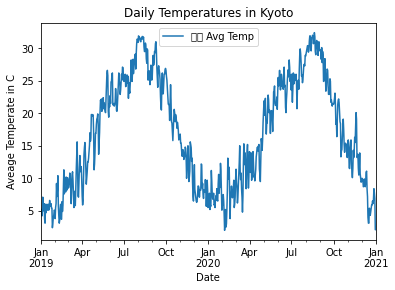

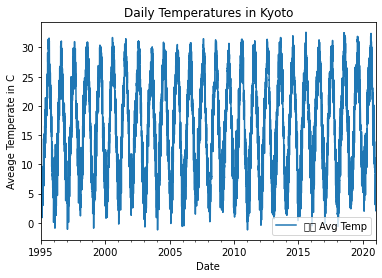

In [12]:
kyoto.plot(y='京都 Avg Temp',ylabel='Aveage Temperate in C',title='Daily Temperatures in Kyoto')

kyoto_from95.plot(y='京都 Avg Temp',ylabel='Aveage Temperate in C',title='Daily Temperatures in Kyoto')

In [11]:
# Code for Posterity
headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Content-Type': "application/x-www-form/urlencoded",
    'Host': 'www.data.jma.go.jp',
    'Origin': 'https://www.data.jma.go.jp',
    'Referer': 'https://www.data.jma.go.jp/gmd/risk/obsdl/index.php'}

In [15]:
1995+26

2021